#### Random Crystallographic Data Generator
Description: Generates a set of random a, b, c, alpha, beta, and gamma values from list of space groups and potential symmetry classifications. Randomly assigns a multi-atom basis, a degree of thermal motion, atomic form factor to each atomic site, a crystallographic orientation, and an X-ray energy to generate a mock-up 'GIWAXS' image. Also randomly generates a set number of 'n'- phases to deconvolve. Used to inform a convolutional neural network for determining space group and symmetry classification, as well as the number of phases in a scattering pattern.

##### 3 Convolutional Neural Networks
1) Peak Finder
2) Phase Classifier
3) Phase Seperator

#### Convolutional Neural Network Peak Finder
Description: Generates a random 'GIWAXS'-like image, as per the description below.

In [1]:
import IPython
print(IPython.__version__)

import tensorflow
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, load_model
print(tensorflow.__version__)

7.34.0
2.6.0


In [2]:
# import tensorflow
# from tensorflow import keras
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from keras.models import Sequential, load_model
import numpy as np
import random, gc, pygix
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import gixsreduce_script as WAXS

%matplotlib widget

def gen_gaussian(m, x_mean, y_mean, x_std_dev, y_std_dev):
    x = np.linspace(-m/2, m/2, m)
    y = np.linspace(0, m, m)
    X, Y = np.meshgrid(x, y)
    return np.exp(-0.5 * ((X-x_mean)/x_std_dev)**2 - 0.5 * ((Y-y_mean)/y_std_dev)**2)

def gen_image(m, n, radial_std_dev=1, azimuthal_std_dev=1, x_std_dev=None, 
              harmonic_probability=0.5, diffuse_gaussian=False, intensity=1.0, 
              min_radius=60, noise_level=0.15):
    
    image = np.zeros((m, m))
    labels = np.zeros((m, m))  # Initialize a blank labels image
    x, y = np.meshgrid(np.linspace(-m/2, m/2, m), np.linspace(0, m, m))

    # Initialize dictionary to log peak and input parameters information
    image_info = {"input_parameters": {"m": m, "n": n, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, 
                                       "x_std_dev": x_std_dev, "harmonic_probability": harmonic_probability, "diffuse_gaussian": diffuse_gaussian, 
                                       "intensity": intensity, "min_radius": min_radius, "noise_level": noise_level},
                  "peaks": []}

    # Transform the grid to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    if diffuse_gaussian:
        r_0 = np.random.rand() * 300 
        radial_std_dev_d = np.random.rand() * 300
        azimuthal_std_dev_d = np.pi
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev_d**2))
        azimuthal_gauss = np.exp(-((theta - np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev_d**2))
        gauss = radial_gauss * azimuthal_gauss
        gauss *= intensity
        image += gauss

    for _ in range(n):
        theta_0 = 2 * np.pi * np.random.rand()
        r_max = m / np.abs(np.sin(theta_0))
        r_0 = min_radius + (r_max - min_radius) * np.random.rand()

        # Log peak position and smearing information
        image_info["peaks"].append({"r_0": r_0, "theta_0": theta_0, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, "is_harmonic": False, "harmonic_number": None})

        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev**2))
        azimuthal_gauss = np.exp(-((theta - theta_0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev**2))
        gauss = radial_gauss * azimuthal_gauss

        # Add x-axis smearing if specified
        if x_std_dev is not None:
            x_gauss = np.exp(-(x - r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))
            gauss *= x_gauss

        # Normalize the Gaussian to have a maximum of 1
        if np.max(gauss) != 0:
            gauss /= np.max(gauss)

        # Add the Gaussian to the image
        image[:, m//2:] += gauss[:, m//2:]

        # Generate a binary label for this peak
        peak_label = (gauss > 0.5).astype(int)

        # Add the peak's label to the overall labels
        labels += peak_label

        if np.random.rand() < harmonic_probability and r_0 > m/6:
            for harmonic in range(2, int(r_max / r_0) + 1):
                radial_gauss = np.exp(-(r - harmonic * r_0)**2 / (2 * radial_std_dev**2))
                gauss = radial_gauss * azimuthal_gauss
                if x_std_dev is not None:
                    gauss *= np.exp(-(x - harmonic*r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))

                if np.max(gauss) != 0:
                    gauss /= np.max(gauss)
                
                # Add the Gaussian to the image
                image[:, m//2:] += gauss[:, m//2:]
                
                # Generate a binary label for this peak
                peak_label = (gauss > 0.5).astype(int)
                
                # Add the peak's label to the overall labels
                labels += peak_label
                
                image_info["peaks"].append({"r_0": harmonic*r_0, "theta_0": theta_0, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, "is_harmonic": True, "harmonic_number": harmonic})

    poisson_noise = np.random.poisson(lam=abs(image), size=(m, m))
    scaled_poisson_noise = noise_level * (2 * poisson_noise - np.mean(poisson_noise)) / np.ptp(poisson_noise)
    gaussian_noise = noise_level * np.random.randn(m, m)
    image += scaled_poisson_noise + gaussian_noise

    # Normalize the image
    image = image / np.max(image)

    # Clamp the image values to the range [0, 1]
    image = np.clip(image, 0, 1)

    # Mirror the right half of the image onto the left half
    image[:, :m//2] = image[:, m//2:][:, ::-1]

    # Clamp the labels values to the range [0, 1]
    labels = np.clip(labels, 0, 1)

    # Mirror the right half of the labels onto the left half
    labels[:, :m//2] = labels[:, m//2:][:, ::-1]

    return image, labels, image_info

    '''
# def create_dataset(num_images, m_range=(400, 600), n_range=(5, 15), radial_std_dev_range=(0.5, 1.5), 
#                    azimuthal_std_dev_range=(0.5, 1.5), x_std_dev_range=(None, None), 
#                    harmonic_probability_range=(0.3, 0.7), diffuse_gaussian_range=(False, True), 
#                    intensity_range=(0.8, 1.2), min_radius_range=(50, 70), noise_level_range=(0.1, 0.2)):
    
#     images = []
#     labels = []
#     info = []

#     for _ in range(num_images):
#         m = np.random.randint(*m_range)
#         n = np.random.randint(*n_range)
#         radial_std_dev = np.random.uniform(*radial_std_dev_range)
#         azimuthal_std_dev = np.random.uniform(*azimuthal_std_dev_range)
#         x_std_dev = np.random.choice([None, np.random.uniform(*x_std_dev_range)])
#         harmonic_probability = np.random.uniform(*harmonic_probability_range)
#         diffuse_gaussian = np.random.choice(diffuse_gaussian_range)
#         intensity = np.random.uniform(*intensity_range)
#         min_radius = np.random.uniform(*min_radius_range)
#         noise_level = np.random.uniform(*noise_level_range)

#         image, label, image_info = gen_image(m, n, radial_std_dev, azimuthal_std_dev, x_std_dev, 
#                                              harmonic_probability, diffuse_gaussian, intensity, 
#                                              min_radius, noise_level)
        
#         images.append(image)
#         labels.append(label)
#         info.append(image_info)
    
#     return np.array(images), np.array(labels), info

# def create_model(input_shape):
#     model = Sequential()  # Sequential model is a linear stack of layers

#     # Add a 2D convolution layer with 32 output filters, a 3x3 kernel, and 'relu' activation function
#     model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))  

#     # Add a 2D max pooling layer with a 2x2 pool size
#     model.add(MaxPooling2D(pool_size=(2, 2))) 

#     # Add another 2D convolution layer with 64 output filters, a 3x3 kernel, and 'relu' activation function
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) 

#     # Add another 2D max pooling layer with a 2x2 pool size
#     model.add(MaxPooling2D(pool_size=(2, 2))) 

#     # Flatten the tensor output from the previous layer to fit into a dense layer
#     model.add(Flatten()) 

#     # Add a dense (fully connected) layer with 64 units and 'relu' activation function
#     model.add(Dense(64, activation='relu')) 

#     # Add a final dense layer with 1 unit (binary classification) and 'sigmoid' activation function
#     model.add(Dense(1, activation='sigmoid')) 

#     # Compile the model with binary cross entropy loss function, 'adam' optimizer, and accuracy as the evaluation metric
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

#     return model
    '''

def apply_mask(m, n, grid_line_width=20):
    # Initialize a mask of ones
    mask = np.zeros((m, m), dtype=np.uint8)

    # Randomly choose 'n' pixel indices to mask
    mask_indices = np.random.choice(mask.size, n, replace=False)
    np.put(mask, mask_indices, 1)
    
    # Define the positions of the grid lines
    grid_positions = [200, 400, 600, 800]

    # Apply the horizontal grid lines
    for pos in grid_positions:
        mask[pos - grid_line_width // 2 : pos + grid_line_width // 2, :] = 1

    # Apply the vertical grid line
    offset = -100
    mask[:, mask.shape[1] // 2 + offset - grid_line_width // 2 : mask.shape[1] // 2 + offset + grid_line_width // 2] = 1

    return mask

def plot_image(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    m = image.shape[0]
    
    im = ax.imshow(image, origin='lower', extent=[-m/2, m/2, 0, m])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Image')
    
    plt.colorbar(im, ax=ax)

# -- Plot generation settings
m = 1000
n = 55
radial_std_dev = 2
azimuthal_std_dev = 12
x_std_dev = 40

# - Random plot generation
image, labels, image_info  = gen_image(m, n, radial_std_dev, azimuthal_std_dev, x_std_dev, harmonic_probability=0.8, diffuse_gaussian=True, intensity=.3, min_radius=60, noise_level=0.15)
print(image_info)

# - Image Corrections Input
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False

mask_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/jun23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf'
poni_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/test.poni'
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

# - Image Corrections Transformation
pg = pygix.Transform()
datafile_dict = {'thpos': 1}
# pg, mask = WAXS.buildDetObj(pg, datafile_dict, corrections, poni_file, mask_file)
pg.sample_orientation = 1

# Generate custom mask in place of the imported mask.
mask = apply_mask(m, n, grid_line_width=20)

# - Perform Image Transformation
recip_data, qxy, qz = WAXS.gixsdataTransform(image, corrections, pg, mask=mask, dark=None, flat=None, case='recip')

# - Plot the Randomly Generated Image
plt.close('all')
gc.collect()
plot_image(recip_data)

Using pyFAI version 2023.5.0
{'input_parameters': {'m': 1000, 'n': 55, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'x_std_dev': 40, 'harmonic_probability': 0.8, 'diffuse_gaussian': True, 'intensity': 0.3, 'min_radius': 60, 'noise_level': 0.15}, 'peaks': [{'r_0': 428.80199527657214, 'theta_0': 4.717378226843769, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': False, 'harmonic_number': None}, {'r_0': 549.0676448568538, 'theta_0': 2.0235726852420575, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': False, 'harmonic_number': None}, {'r_0': 301.5551731661597, 'theta_0': 2.025139991860215, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': False, 'harmonic_number': None}, {'r_0': 603.1103463323194, 'theta_0': 2.025139991860215, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': True, 'harmonic_number': 2}, {'r_0': 904.6655194984792, 'theta_0': 2.025139991860215, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': True, 'harmonic_number'

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

#### Random 'GIWAXS' Image Generator
Description: Generates a random 'GIWAXS'-like image with Gaussian/Poissonian noise, random Gaussian peaks smeared azimuthally, radially, and along qxy, random harmonic n-multiple peaks, a mask with random dead pixels, and pyFAI azimuthal integration transform. To be used to train a convolutional neural network.

{'input_parameters': {'m': 1000, 'n': 55, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'x_std_dev': 40, 'harmonic_probability': 0.8, 'diffuse_gaussian': True, 'intensity': 0.3, 'min_radius': 60, 'noise_level': 0.15}, 'peaks': [{'r_0': 939.9666492972832, 'theta_0': 5.34885223930822, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': False, 'harmonic_number': None}, {'r_0': 393.2107926341614, 'theta_0': 2.243592824523643, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': False, 'harmonic_number': None}, {'r_0': 786.4215852683228, 'theta_0': 2.243592824523643, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': True, 'harmonic_number': 2}, {'r_0': 1179.6323779024842, 'theta_0': 2.243592824523643, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': True, 'harmonic_number': 3}, {'r_0': 481.36587449273685, 'theta_0': 5.370800732153106, 'radial_std_dev': 2, 'azimuthal_std_dev': 12, 'is_harmonic': False, 'harmonic_number': None}, {'r_0': 853.850848805786

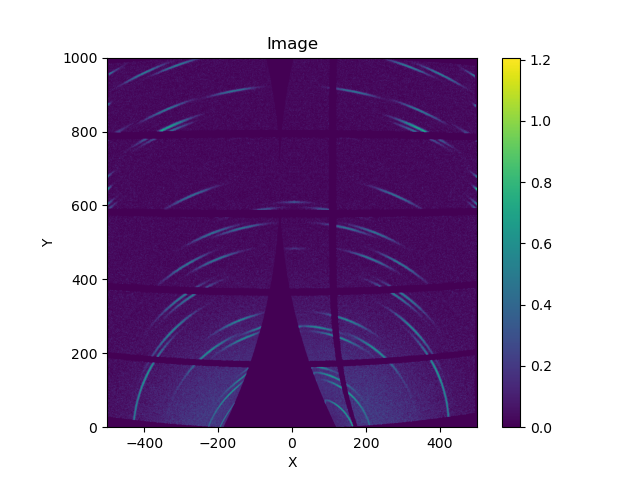

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import random, gc
import pygix
import gixsreduce_script as WAXS

%matplotlib widget

def gen_gaussian(m, x_mean, y_mean, x_std_dev, y_std_dev):
    x = np.linspace(-m/2, m/2, m)
    y = np.linspace(0, m, m)
    X, Y = np.meshgrid(x, y)
    return np.exp(-0.5 * ((X-x_mean)/x_std_dev)**2 - 0.5 * ((Y-y_mean)/y_std_dev)**2)

def gen_image(m=1000, n=50, radial_std_dev=1, azimuthal_std_dev=1, x_std_dev=None, harmonic_probability=0.5, diffuse_gaussian=False, intensity=1.0, min_radius=60, noise_level=0.15):
    image = np.zeros((m, m))
    x, y = np.meshgrid(np.linspace(-m/2, m/2, m), np.linspace(0, m, m))
    
    # Initialize dictionary to log peak and input parameters information
    image_info = {"input_parameters": {"m": m, "n": n, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, 
                                       "x_std_dev": x_std_dev, "harmonic_probability": harmonic_probability, "diffuse_gaussian": diffuse_gaussian, 
                                       "intensity": intensity, "min_radius": min_radius, "noise_level": noise_level},
                  "peaks": []}

    # Transform the grid to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    if diffuse_gaussian:
        r_0 = np.random.rand() * 300 # Randomly choose r_0 within 0 to 300
        radial_std_dev_d = np.random.rand() * 300 # Randomly choose standard deviation within 0 to 300
        azimuthal_std_dev_d = np.pi
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev_d**2))
        azimuthal_gauss = np.exp(-((theta - np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev_d**2))
        gauss = radial_gauss * azimuthal_gauss
        gauss *= intensity
        image += gauss

    for _ in range(n):
        # Generate a random angle
        theta_0 = 2 * np.pi * np.random.rand()

        # Calculate the maximum possible radius at this angle
        r_max = m / np.abs(np.sin(theta_0))

        # Generate a random radius within [min_radius, r_max]
        r_0 = min_radius + (r_max - min_radius) * np.random.rand()

        # Log peak position and smearing information
        image_info["peaks"].append({"r_0": r_0, "theta_0": theta_0, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, "is_harmonic": False, "harmonic_number": None})

        # Create the radial Gaussian centered around the randomly generated radius
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev**2))

        # Create the azimuthal Gaussian centered around the randomly generated angle
        azimuthal_gauss = np.exp(-((theta - theta_0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev**2))

        # Generate the Gaussian as the product of the radial and azimuthal Gaussians
        gauss = radial_gauss * azimuthal_gauss

        # Add x-axis smearing if specified
        if x_std_dev is not None:
            x_gauss = np.exp(-(x - r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))
            gauss *= x_gauss

        # Normalize the Gaussian to have a maximum of 1
        if np.max(gauss) != 0:
            gauss /= np.max(gauss)

        # Add the Gaussian to the image
        image[:, m//2:] += gauss[:, m//2:]

        # Generate harmonic multiples if the original radius is greater than m/6
        if np.random.rand() < harmonic_probability and r_0 > m/6:
            for harmonic in range(2, int(r_max / r_0) + 1):
                # Create the radial Gaussian centered around the harmonic multiple of the original radius
                radial_gauss = np.exp(-(r - harmonic * r_0)**2 / (2 * radial_std_dev**2))

                # Generate the Gaussian as the product of the radial and azimuthal Gaussians
                gauss = radial_gauss * azimuthal_gauss

                # Add x-axis smearing if specified
                if x_std_dev is not None:
                    gauss *= np.exp(-(x - harmonic*r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))

                # Normalize the Gaussian to have a maximum of 1
                if np.max(gauss) != 0:
                    gauss /= np.max(gauss)

                # Add the Gaussian to the image
                image[:, m//2:] += gauss[:, m//2:]
                
                # Log peak position and smearing information for harmonics
                image_info["peaks"].append({"r_0": harmonic*r_0, "theta_0": theta_0, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, "is_harmonic": True, "harmonic_number": harmonic})

    # Add Poisson noise to the image
    poisson_noise = np.random.poisson(lam=abs(image), size=(m, m))
    scaled_poisson_noise = noise_level * (2 * poisson_noise - np.mean(poisson_noise)) / np.ptp(poisson_noise) # scale poisson noise to be within +/- 15% of baseline

    # Add Gaussian noise to the image
    gaussian_noise = noise_level * np.random.randn(m, m)
    image += scaled_poisson_noise + gaussian_noise

    # Normalize the image
    image = image / np.max(image)

    # Clamp the image values to the range [0, 1]
    image = np.clip(image, 0, 1)

    # Mirror the right half of the image onto the left half
    image[:, :m//2] = image[:, m//2:][:, ::-1]

    return image, image_info

def apply_mask(m, n, grid_line_width=20):
    # Initialize a mask of ones
    mask = np.zeros((m, m), dtype=np.uint8)

    # Randomly choose 'n' pixel indices to mask
    mask_indices = np.random.choice(mask.size, n, replace=False)
    np.put(mask, mask_indices, 1)
    
    # Define the positions of the grid lines
    grid_positions = [200, 400, 600, 800]

    # Apply the horizontal grid lines
    for pos in grid_positions:
        mask[pos - grid_line_width // 2 : pos + grid_line_width // 2, :] = 1

    # Apply the vertical grid line
    offset = -100
    mask[:, mask.shape[1] // 2 + offset - grid_line_width // 2 : mask.shape[1] // 2 + offset + grid_line_width // 2] = 1

    return mask

def plot_image(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    m = image.shape[0]
    
    im = ax.imshow(image, origin='lower', extent=[-m/2, m/2, 0, m])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Image')
    
    plt.colorbar(im, ax=ax)

# -- Plot generation settings
m = 1000
n = 55
radial_std_dev = 2
azimuthal_std_dev = 12
x_std_dev = 40

# - Random plot generation
image, peak_info  = gen_image(m, n, radial_std_dev, azimuthal_std_dev, x_std_dev, harmonic_probability=0.8, diffuse_gaussian=True, intensity=.3, min_radius=60, noise_level=0.15)
print(peak_info)

# - Image Corrections Input
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False

mask_file = '/Users/keithwhite/github_repositories/pyWAXS/examples/calib_files/ponimask/may23/may23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf'
# poni_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/test.poni'
poni_file = '/Users/keithwhite/github_repositories/pyWAXS/examples/calib_files/ponimask/may23/may23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni'
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

# - Image Corrections Transformation
pg = pygix.Transform()
datafile_dict = {'thpos': 1}
pg, mask = WAXS.buildDetObj(pg, datafile_dict, corrections, poni_file, mask_file)
pg.sample_orientation = 1

# Generate custom mask in place of the imported mask.
mask = apply_mask(m, n, grid_line_width=20)

# - Perform Image Transformation
recip_data, qxy, qz = WAXS.gixsdataTransform(image, corrections, pg, mask=mask, dark=None, flat=None, case='recip')

# - Plot the Randomly Generated Image
# plt.close('all')
# gc.collect()
plot_image(recip_data)


#### Monte Carlo Peak Finder (v1)

In [8]:
import numpy as np
import scipy.fftpack as fftpack
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import gc
import time
from collections import defaultdict
from scipy.optimize import minimize

%matplotlib widget

def generate_gaussian_heatmap(height, width, num_gaussians, gaussian_std, amplitude_range):
    heatmap = np.zeros((height, width))
    true_peak_centers = []

    for _ in range(num_gaussians):
        amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
        center_y, center_x = np.random.randint(0, height), np.random.randint(0, width)
        true_peak_centers.append((center_y, center_x))
        y, x = np.mgrid[0:height, 0:width]
        heatmap += amplitude * np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * gaussian_std ** 2))

    return heatmap, np.array(true_peak_centers)

def monte_carlo_peak_finding(heatmap, m, n, gradient_threshold):
    height, width = heatmap.shape
    visited = np.zeros_like(heatmap, dtype=bool)

    peak_centers = []

    for _ in range(m):
        start_point = np.random.randint(0, height), np.random.randint(0, width)

        for _ in range(n):
            y, x = start_point
            neighborhood = heatmap[max(y - 1, 0):min(y + 2, height), max(x - 1, 0):min(x + 2, width)]
            next_point = np.unravel_index(np.argmax(neighborhood), neighborhood.shape)
            next_point = next_point[0] + max(y - 1, 0), next_point[1] + max(x - 1, 0)

            if next_point == start_point:
                break
            else:
                start_point = next_point

        y, x = start_point
        if not visited[y, x]:
            peak_centers.append(start_point)

            # Turn off the region around the peak center
            grad_y, grad_x = np.gradient(heatmap)
            gradient_magnitude = np.sqrt(grad_y ** 2 + grad_x ** 2)
            mask = gradient_magnitude < gradient_threshold
            visited[mask] = True

    return np.array(peak_centers)

def fourier_filter_and_find_peaks(heatmap, cutoff_frequency, m, n, gradient_threshold):
    # Apply the Fourier transform to the heatmap
    fft_heatmap = fftpack.fft2(heatmap)

    # Create a low-pass filter in the frequency domain
    rows, cols = heatmap.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    low_pass_filter = np.zeros((rows, cols))
    low_pass_filter[crow - cutoff_frequency:crow + cutoff_frequency, ccol - cutoff_frequency:ccol + cutoff_frequency] = 1

    # Apply the low-pass filter to the heatmap in the frequency domain
    filtered_fft_heatmap = fft_heatmap * low_pass_filter

    # Transform the filtered heatmap back to the spatial domain
    filtered_heatmap = np.real(fftpack.ifft2(filtered_fft_heatmap))

    # Run the Monte Carlo peak finding algorithm on the filtered heatmap
    peak_centers = monte_carlo_peak_finding(filtered_heatmap, m, n, gradient_threshold)

    return peak_centers

def looped_monte_carlo_peak_finding(heatmap, cutoff_frequency, m, n, gradient_threshold, num_iterations, reproducibility_threshold, edge_removal):
    gc.collect()

    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    peaks_count = defaultdict(int)
    all_peaks = []

    for _ in range(num_iterations):
        np.random.seed(int(time.time() * 1e6) % 2**32)  # Set seed based on the current time
        peak_centers = fourier_filter_and_find_peaks(heatmap, cutoff_frequency, m, n, gradient_threshold)

        for peak in peak_centers:
            peak = tuple(peak)  # Convert numpy array to tuple
            all_peaks.append(peak)
            for other_peak in all_peaks:
                if distance(peak, other_peak) <= reproducibility_threshold:
                    peaks_count[other_peak] += 1
                    break

    reproducible_peaks = [peak for peak, count in peaks_count.items() if count >= num_iterations / 2]

    # Remove peaks at image edges
    reproducible_peaks = [(x, y) for x, y in reproducible_peaks if edge_removal <= x < heatmap.shape[0] - edge_removal and edge_removal <= y < heatmap.shape[1] - edge_removal]

    return np.array(reproducible_peaks)

def plot_heatmap_and_peaks(heatmap, peak_centers):
    plt.figure()
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    
    if peak_centers.size > 0:
        plt.scatter(peak_centers[:, 1], peak_centers[:, 0], c='blue', marker='x', s=50)
    
    plt.colorbar()
    plt.show()

def peak_finding_score(true_peak_centers, detected_peak_centers, tolerance):
    true_peak_centers = set(tuple(p) for p in true_peak_centers)
    detected_peak_centers = set(tuple(p) for p in detected_peak_centers)
    score = 0

    for true_peak in true_peak_centers:
        if not any(np.linalg.norm(np.array(true_peak) - np.array(detected_peak)) <= tolerance for detected_peak in detected_peak_centers):
            score += 1
    
    for detected_peak in detected_peak_centers:
        if not any(np.linalg.norm(np.array(true_peak) - np.array(detected_peak)) <= tolerance for true_peak in true_peak_centers):
            score += 1

    return score

def optimize_parameters(heatmap, true_peak_centers, initial_parameters, bounds):
    def objective_function(parameters):
        cutoff_frequency, m, n, gradient_threshold, num_iterations, reproducibility_threshold, edge_removal = parameters
        m, n, num_iterations, edge_removal = int(m), int(n), int(num_iterations), int(edge_removal)
        detected_peak_centers = looped_monte_carlo_peak_finding(heatmap, cutoff_frequency, m, n, gradient_threshold, num_iterations, reproducibility_threshold, edge_removal)
        score = peak_finding_score(true_peak_centers, detected_peak_centers, tolerance=5)
        return score

    result = minimize(objective_function, initial_parameters, bounds=bounds, method='L-BFGS-B')
    return result.x

# # Example usage
heatmap = generate_gaussian_heatmap(100, 100, 20, 5, (10, 50))
cutoff_frequency = 5
m = 50
n = 10
gradient_threshold = 0.1
num_iterations = 5
reproducibility_threshold = 5
edge_removal = 1

reproducible_peak_centers = looped_monte_carlo_peak_finding(heatmap, cutoff_frequency, m, n, gradient_threshold, num_iterations, reproducibility_threshold, edge_removal)
print(reproducible_peak_centers)

plot_heatmap_and_peaks(heatmap, reproducible_peak_centers)

# Example usage
# height, width = 100, 100
# num_gaussians = 20
# gaussian_std = 5
# amplitude_range = (10, 50)

# heatmap, true_peak_centers = generate_gaussian_heatmap(height, width, num_gaussians, gaussian_std, amplitude_range)

# initial_parameters = [5, 50, 10, 0.1, 5, 5, 1]  # Initial values for [cutoff_frequency, m, n, gradient_threshold, num_iterations, reproducibility_threshold, edge_removal]
# bounds = [(1, 20), (1, 200), (1, 100), (0.001, 1), (1, 10), (1, 20), (0, 10)]  # Bounds for the parameters

# optimized_parameters = optimize_parameters(heatmap, true_peak_centers, initial_parameters, bounds)
# print("Optimized parameters:", optimized_parameters)

# reproducible_peak_centers = looped_monte_carlo_peak_finding(heatmap, *optimized_parameters)
# print(reproducible_peak_centers)

# plot_heatmap_and_peaks(heatmap, reproducible_peak_centers)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

#### Monte Carlo Peak Finder (v2)

In [9]:
import os, re, sys, gc, time
import numpy as np
from numpy import unravel_index # used to grab amax index from np_array
import scipy as sc
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
import random
from random import seed

# %matplotlib widget

# -- Functionality Description
# mcpointgen() - Generate pseudo-random set of points.
# checkneighborhood() - For each point, return the local maxima.
# checkneighborhood_inverted() - Take the same data matrix, reverse the topology and repeat to return the local maxima.
# get_group_statistics() - Takes the set of points from the checkneighborhood() function and groups them according to an input proximity value. Returns the a dictionary of group statistics.
# remove_common_sets() - Removes index pairs found in both the regular and inverted local max data sets. These pairs are saddle points found from both local minima and maxima approach methods - they are not true peaks.
# mcpeakfinder() - Wraps the functions above to find peaks, compress into two groups, and remove saddle points. Returns the post-process indices.

# Notes for further improvements: 
    # kd tree - algorithm for sorting points 
    # import scipy.spatial.KDTree
    # sphere point picking
    # steepest ascent methods/saddle point approximation

def normalize_array(arr):
    max_val = np.max(arr)
    normalized_arr = arr / max_val
    return normalized_arr

# -- Description: Outputs a seeded set number of pseduo-random indices over the define grid space parameters.
def mcpointgen(seednum=1, genPoints=1000, pixeldimX=1000, pixeldimY=1000):
    """
    Seeded pseudo-random number generator for use with 2D Monte-Carlo peak finder.
    Returns an array of shape (genPoints, 2) containing randomly generated (x, y) coordinates.

    Parameters:
    seednum : int, optional
        Seed value used to produce the random numbers. Default is 1.
    genPoints : int, optional
        Number of random points generated on the rangeX x rangeY grid. Default is 1000.
    pixeldimX : int, optional
        Pixel dimensions in X over data set. Default is 1000.
    pixeldimY : int, optional
        Pixel dimensions in Y over data set. Default is 1000.

    Returns:
    np_mcrand : numpy array
        Array of shape (genPoints, 2) containing randomly generated (x, y) coordinates.
    """

    np.random.seed(seednum)
    np_mcrand = np.random.randint(0, pixeldimX, size=(genPoints, 2), dtype=int)
    return np_mcrand

# -- Description: Returns a single peak position it finds by walking in direction of increasing intensity.
def checkneighborhoodmax(data_nparray, pixindexX, pixindexY, radius=5, pixeldimX=1000, pixeldimY=1000, threshold=0.005):
    """Checks the pixel neighborhood for the local maximum with respect to the input pixel indices (x,y). 
    Returns the coordinates of the maximum pixel.
    Input parameters:
    data_nparray : numpy array
        input numpy array, indexed values will be typecasted as needed.
    pixindexX : int
        centered pixel index in x w/ respect to pixel array
    pixindexY : int
        centered pixel index in y w/ respect to pixel array
    radius : int
        radius about the pixel center (non-inclusive) that 
        defines the neighborhood parameter space to check for
        the maxima in this range. 
    threshold : float64
        decimal val (0-1), defines the percentage difference 
        needed for moving to a different pixel as origin."""

    pixminX = int(pixindexX - radius) # defines the boxed pixel neighborhood x-index minimum (x,y)
    pixmaxX = int(pixindexX + radius) # defines the boxed pixel neighborhood x-index maximum (x,y)

    pixminY = int(pixindexY - radius) # defines the boxed pixel neighborhood y-index minimum (x,y)
    pixmaxY = int(pixindexY + radius) # defines the boxed pixel neighborhood y-index maximum (x,y)

    # pixrangeX = (pixmaxX - pixminX) + 1
    # pixrangeY = (pixmaxY - pixminY) + 1

    origincoord = (pixindexX, pixindexY) # store the origin coordinates as a tuple to make them immutable

    loop = True
    counter = 0
    while loop == True:
        counter += 1
        # if statement fail-safes in case we hit the edge of the img array
        if pixmaxX > pixeldimX:
            pixmaxX = pixeldimX-1 # -1 because indexing from 0
        
        if pixmaxY > pixeldimY:
            pixmaxY = pixeldimY-1 # -1 because indexing from 0
        
        if pixminX < 0:
            pixminX = 0
        
        if pixminY < 0:
            pixminY = 0

        centerpix_intensity = data_nparray[pixindexX, pixindexY] # grab the center pixel intensity
        subset_nparray = data_nparray[pixminX:pixmaxX, pixminY:pixmaxY] # create the subset array

        temp_origincoord = list(unravel_index(subset_nparray.argmax(), subset_nparray.shape)) # get the indices of the subset array maximum
        temp_centerpix_intensity = subset_nparray[int(temp_origincoord[0]), int(temp_origincoord[1])] # get the intensity of the subset array maximum
        
        d_intensity = temp_centerpix_intensity - centerpix_intensity # calculate the delta intensity between current origin and the new candidate origin (should be positive above threshold to make the move)
        # print ('d_intensity = ', str(d_intensity))
    
        d_threshold = threshold * centerpix_intensity # threshold default = 0.05 (5% of center pixel intensity)
        # print ('d_threshold = ', str(d_threshold))

        # if the center pixel intensity is less than or equal to (threshold default = 5%) percent smaller than the next pixel, stop the search
        if d_intensity <= d_threshold:
            loop = False # kill the loop
            if d_intensity > 0: # if the intensity is greater, reassign the points to the final position (because why not)
                pixindexX = pixminX + int(temp_origincoord[0]) # set the new index bounds in X
                pixindexY = pixminY + int(temp_origincoord[1]) # set the new index bounds in Y
        else: # otherwise, rewrite the pixel index center to repeat the sequence
            pixindexX = pixminX + int(temp_origincoord[0]) # set the new index bounds in X
            pixindexY = pixminY + int(temp_origincoord[1]) # set the new index bounds in Y

            pixminX = int(pixindexX - radius) # change the pixel neighborhood zone x-min
            pixmaxX = int(pixindexX + radius) # change the pixel neighborhood zone x-max

            pixminY = int(pixindexY - radius) # change the pixel neighborhood zone y-min
            pixmaxY = int(pixindexY + radius) # change the pixel neighborhood zone y-max

    # return the pixel indices of the greater array
    return pixindexX, pixindexY

# -- Description: Returns a single peak position it finds by walking in direction of decreasing intensity.
def checkneighborhoodmin(data_nparray, pixindexX, pixindexY, radius=5, pixeldimX=1000, pixeldimY=1000, threshold=0.005):
    """Checks the pixel neighborhood for the local maximum with respect to the input pixel indices (x,y). 
    Returns the coordinates of the maximum pixel.
    Input parameters:
    data_nparray : numpy array
        input numpy array, indexed values will be typecasted as needed.
    pixindexX : int
        centered pixel index in x w/ respect to pixel array
    pixindexY : int
        centered pixel index in y w/ respect to pixel array
    radius : int
        radius about the pixel center (non-inclusive) that 
        defines the neighborhood parameter space to check for
        the maxima in this range. 
    threshold : float64
        decimal val (0-1), defines the percentage difference 
        needed for moving to a different pixel as origin."""

    pixminX = int(pixindexX - radius) # defines the boxed pixel neighborhood x-index minimum (x,y)
    pixmaxX = int(pixindexX + radius) # defines the boxed pixel neighborhood x-index maximum (x,y)

    pixminY = int(pixindexY - radius) # defines the boxed pixel neighborhood y-index minimum (x,y)
    pixmaxY = int(pixindexY + radius) # defines the boxed pixel neighborhood y-index maximum (x,y)

    # pixrangeX = (pixmaxX - pixminX) + 1
    # pixrangeY = (pixmaxY - pixminY) + 1

    origincoord = (pixindexX, pixindexY) # store the origin coordinates as a tuple to make them immutable

    loop = True
    counter = 0
    while loop == True:
        counter += 1
        # if statement fail-safes in case we hit the edge of the img array
        if pixmaxX > pixeldimX:
            pixmaxX = pixeldimX-1 # -1 because indexing from 0
        
        if pixmaxY > pixeldimY:
            pixmaxY = pixeldimY-1 # -1 because indexing from 0
        
        if pixminX < 0:
            pixminX = 0
        
        if pixminY < 0:
            pixminY = 0

        centerpix_intensity = data_nparray[pixindexX, pixindexY] # grab the center pixel intensity
        subset_nparray = data_nparray[pixminX:pixmaxX, pixminY:pixmaxY] # create the subset array

        temp_origincoord = list(unravel_index(subset_nparray.argmin(), subset_nparray.shape)) # get the indices of the subset array minimum
        temp_centerpix_intensity = subset_nparray[int(temp_origincoord[0]), int(temp_origincoord[1])] # get the intensity of the subset array minimum
        
        # d_intensity = temp_centerpix_intensity - centerpix_intensity # calculate the delta intensity between current origin and the new candidate origin (should be positive above threshold to make the move)
        # print ('d_intensity = ', str(d_intensity))
    
        d_intensity =  centerpix_intensity - temp_centerpix_intensity

        d_threshold = threshold * centerpix_intensity # threshold default = 0.05 (5% of center pixel intensity)
        # print ('d_threshold = ', str(d_threshold))

        # if the center pixel intensity is less than or equal to (threshold default = 5%) percent smaller than the next pixel, stop the search
        if d_intensity <= d_threshold:
            loop = False # kill the loop
            if d_intensity > 0: # if the intensity is greater, reassign the points to the final position (because why not)
                pixindexX = pixminX + int(temp_origincoord[0]) # set the new index bounds in X
                pixindexY = pixminY + int(temp_origincoord[1]) # set the new index bounds in Y
        else: # otherwise, rewrite the pixel index center to repeat the sequence
            pixindexX = pixminX + int(temp_origincoord[0]) # set the new index bounds in X
            pixindexY = pixminY + int(temp_origincoord[1]) # set the new index bounds in Y

            pixminX = int(pixindexX - radius) # change the pixel neighborhood zone x-min
            pixmaxX = int(pixindexX + radius) # change the pixel neighborhood zone x-max

            pixminY = int(pixindexY - radius) # change the pixel neighborhood zone y-min
            pixmaxY = int(pixindexY + radius) # change the pixel neighborhood zone y-max

    # return the pixel indices of the greater array
    return pixindexX, pixindexY

# -- Description: Inverts the input array to look for local maxima. Repeats with the checkneighborhood() function will be thrown out.
def checkneighborhood_inverted(data_nparray, pixindexX, pixindexY, radius=5, pixeldimX=1000, pixeldimY=1000, threshold=0.005):
    """Checks the pixel neighborhood for the local maximum with respect to the input pixel indices (x,y).
    Inverts the input array by multiplying it by -1 before processing.
    Returns the coordinates of the maximum pixel.
    Input parameters:
    data_nparray : numpy array
        input numpy array, indexed values will be typecasted as needed.
    pixindexX : int
        centered pixel index in x w/ respect to pixel array
    pixindexY : int
        centered pixel index in y w/ respect to pixel array
    radius : int
        radius about the pixel center (non-inclusive) that 
        defines the neighborhood parameter space to check for
        the maxima in this range. 
    threshold : float64
        decimal val (0-1), defines the percentage difference 
        needed for moving to a different pixel as origin."""

    # Invert the input array by multiplying it by -1
    data_nparray_inverted = -1 * data_nparray

    # Call the original checkneighborhood function with the inverted data array
    pixindexX_inverted, pixindexY_inverted = checkneighborhoodmax(data_nparray_inverted, pixindexX, pixindexY, radius, pixeldimX, pixeldimY, threshold)

    return pixindexX_inverted, pixindexY_inverted, data_nparray_inverted

# -- Description: Finds peaks located on an input image array using the pseudo-randomly seeded points and neighborhood() functionality.
def mc_findpeaks(data_nparray, radius=5, seednum=1, genPoints=1000, pixeldimX=1000, pixeldimY=1000, threshold=0.005):

    np_mcrand = mcpointgen(seednum, genPoints, pixeldimX, pixeldimY) # generate array of random points
    np_mcrand_length = int(list(np.shape(np_mcrand))[0]) # get length of the np_mcrand array (should be genPoints input)

    locmax_indices = np.zeros([int(list(np.shape(np_mcrand))[0]), int(list(np.shape(np_mcrand))[1])]) # local max array
    locmin_indices = np.zeros([int(list(np.shape(np_mcrand))[0]), int(list(np.shape(np_mcrand))[1])]) # local min array

    i = 0
    for i in range(0, np_mcrand_length-1):
        pixindexX = int(np_mcrand[i,0]) # grab the seeded pseudo-random index x in (x,y)
        pixindexY = int(np_mcrand[i,1]) # grab the seeded pseudo-random index y in (x,y)

        locmaxX, locmaxY = checkneighborhoodmax(data_nparray, pixindexX, pixindexY, radius=radius, pixeldimX=pixeldimX, pixeldimY=pixeldimY, threshold=threshold) # get the regular local maxima indices
        locminX, locminY = checkneighborhoodmin(data_nparray, pixindexX, pixindexY, radius=radius, pixeldimX=pixeldimX, pixeldimY=pixeldimY, threshold=threshold) # get the regular local minima indices
        # invlocmaxX, invlocmaxY, invdata_nparray = checkneighborhood_inverted(data_nparray, pixindexX, pixindexY, radius=radius, pixeldimX=pixeldimX, pixeldimY=pixeldimY, threshold=threshold) # get the inverted local maxima indices

        locmax_indices[i, 0] = locmaxX # store normal local max X-coordinate
        locmax_indices[i, 1] = locmaxY # store normal local max Y-coordinate

        locmin_indices[i, 0] = locminX # store the local max X-coord of the inverted image
        locmin_indices[i, 1] = locminY # store the local max Y-coord of the inverted image

    # return locmax_indices, invlocmax_indices, invdata_nparray
    return locmax_indices, locmin_indices

# -- Description: Groups coordinate pairs based on proximity and returns a dictionary of statistical information on the pairwise groupings.
def get_group_statistics(intensity_data, indices, proximity):
    # Compute pairwise distances between indices
    distances = cdist(indices, indices)

    # Group indices that are closer than proximity threshold
    groups = []
    for i in range(len(indices)):
        group = np.where(distances[i] < proximity)[0]
        groups.append(group)

    # Remove duplicate groups and sort by size
    unique_groups = []
    for group in groups:
        if set(group) not in unique_groups:
            unique_groups.append(set(group))
    unique_groups.sort(key=len, reverse=True)

    # Compute statistics for each group
    group_stats = {}
    group_indices = []
    for i, group in enumerate(unique_groups):
        group_indices_in_array = indices[list(group)].astype(int)
        group_intensity = intensity_data[group_indices_in_array[:, 0], group_indices_in_array[:, 1]]
        group_max_intensity_index = np.argmax(group_intensity)
        group_max_intensity = group_intensity[group_max_intensity_index]
        group_max_intensity_indices = group_indices_in_array[group_max_intensity_index]
        group_size = len(group)
        group_stats[f"group_{i+1}"] = {"max_intensity": group_max_intensity,
                                       "max_intensity_indices": group_max_intensity_indices,
                                       "size": group_size}
        group_indices.append(group_max_intensity_indices)

    # Convert grouped indices from list of tuples to numpy array
    grouped_indices = np.array(group_indices)

    return group_stats, grouped_indices

# -- Description: Groups coordinate pairs together based on proximity.
def group_within_proximity(array1, array2, proximity):
    # Compute pairwise distances between the two arrays
    distances = cdist(array1, array2)

    # Group elements of array2 that are closer than proximity threshold to any element of array1
    groups = []
    for i in range(len(array1)):
        group = np.where(distances[i] < proximity)[0]
        groups.append(group)

    # Remove duplicates from group indices and sort by size
    unique_groups = []
    for group in groups:
        if set(group) not in unique_groups:
            unique_groups.append(set(group))
    unique_groups.sort(key=len, reverse=True)

    # Compute final array by selecting only unique elements of array2 that are not within proximity of any element of array1
    final_array = []
    for i in range(len(array2)):
        is_within_proximity = False
        for group in unique_groups:
            if i in group:
                is_within_proximity = True
                break
        if not is_within_proximity:
            final_array.append(array2[i])

    return np.array(final_array)

# -- Description: Checks local minima/maxima against one another to eliminate values that fall into bifurcations.
def compare_local_extrema(array1, array2, proximity):
    # Get grouped indices for array1 and array2
    # _, grouped_indices1 = get_group_statistics(intensity_data, array1, proximity)
    # _, grouped_indices2 = get_group_statistics(intensity_data, array2, proximity)
    
    # Filter indices in grouped_indices2 that are within proximity of indices in grouped_indices1
    filtered_indices = []
    for i in range(len(array2)):
        keep = True
        for j in range(len(array1)):
            dist = np.sqrt((array2[i][0]-array1[j][0])**2 + (array2[i][1]-array1[j][1])**2)
            if dist <= proximity:
                keep = False
                break
        if keep:
            filtered_indices.append(array2[i])
    
    # Convert filtered indices to numpy array
    filtered_array2 = np.array(filtered_indices)
    
    return filtered_array2

# -- Description: Takes the local max/inverted local max indices and removes common sets using the symmetric difference method.
def remove_common_sets(array1, array2, return_from_array1=True):
    """
    Takes two input arrays of dimensions (n, 2) and (m, 2), in which n does not necessarily = m in dimensionality. 
    Takes the symmetric difference of these sets and returns the input 'array1' with the matching sets from 'array2' removed.

    Note: No pairs or elements from the input 'array2' will be returned, only the pairs from 'array1' with matching pairs from
    'array2' removed.
    
    Args:
    array1 (np array) of dim (n, 2) : The size of the input array - should be the output locmax_indices.
    array2 (np array) of dim (m, 2) : The size of the input array - should be the output invlocmax_indices."""

    # Convert the arrays to sets of tuples
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))

    # Find the symmetric difference between the two sets
    diff = set1.symmetric_difference(set2)

    # In set theory, the symmetric difference of two sets is the set of elements 
    # that are in either of the sets but not in their intersection. In other words, 
    # it is the set of elements that belong to one of the sets but not both. 
    # The symmetric difference is denoted by the symbol "∆" or "⊕". For example, 
    # if A = {1, 2, 3} and B = {3, 4, 5}, then A ∆ B = {1, 2, 4, 5}.

    # Find the elements that are in array1 or array2, depending on the option
    if return_from_array1:
        unique_pairs = np.array(list(set1.intersection(diff)))
    else:
        unique_pairs = np.array(list(set2.intersection(diff)))

    return unique_pairs

# -- Description: Finds all peaks using a Monte-Carlo pseudo-random number generator method and set theory to group points based on pairwise distances.
def mcpeakfinder(data_nparray, radius=5, seednum=2, genPoints=2000, pixeldimX=1000, pixeldimY=1000, threshold=0.001, prox1=4, prox2=35, proxextrema=20, proxfinal=10):
    # array = random_gaussians(size=1000, num_gaussians=30, max_intensity=1) # used to generate array of 

    data_nparray = normalize_array(data_nparray)
    locmax_indices, locmin_indices = mc_findpeaks(data_nparray, radius=radius, seednum=seednum, genPoints=genPoints, pixeldimX=pixeldimX, pixeldimY=pixeldimY, threshold=threshold)

    # find the local maxima.
    locmax_stats, locmax_group = get_group_statistics(data_nparray, locmax_indices, proximity=prox1) # fine local gap grouping
    locmax_stats, locmax_group = get_group_statistics(data_nparray, locmax_group, proximity=prox2) # coarse broad gap grouping

    # group the local maxima indices.
    locmin_stats, locmin_group = get_group_statistics(data_nparray, locmin_indices, proximity=prox1) # fine local gap grouping
    locmin_stats, locmin_group = get_group_statistics(data_nparray, locmin_group, proximity=prox2) # coarse broad gap grouping

    # remove the saddle points by finding redundancies in minima and maxima from the sets.
    locmax_group = compare_local_extrema(locmin_group, locmax_group, proximity=proxextrema) # extrema grouping

    # remove common 
    peakindices = remove_common_sets(locmax_group, locmin_group)
    peakindices_stats, peakindices = get_group_statistics(data_nparray, peakindices, proximity=proxfinal) # coarse broad gap grouping
    
    return peakindices, peakindices_stats, data_nparray

# -- Description: Plots the image data along with peak markers.
# def plot_intensity_with_markers(data_nparray, peakindices, plotParams, imgParams, marker='o', color='g'):
def plot_intensity_with_markers(data_nparray, peakindices, marker='o', color='g'):
    
    plt.close('all')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(data_nparray, cmap='turbo')
    norm = plt.Normalize(vmin=data_nparray.min(), vmax=data_nparray.max()) # Normalize the intensity data
    cmap = get_cmap('turbo') # Define the colormap

    # -----
    # samplename, qxymax, qzmax, xmin, xmax, ymin, ymax, cmin, cmax, cmap, cblabel, cbsize, scaleLog, header, headerfontsize, xfontsize, yfontsize, tickfontsize, autosave, imgdpi, ext, colorscale, fsize, hklcutoff  = plotParams
    # resolutionx, qxymax, qzmax, qzmin = imgParams

    # fig, ax = plt.subplots(figsize = fsize) # Set up the plot
    # cmap = get_cmap('turbo') # Define the colormap
    # extent = -qxymax, qxymax, 0, qzmax

    # ax.imshow(data_nparray,
    #                 #  norm=matplotlib.colors.Normalize(vmin=contrastmin,vmax=contrastmax),
    #                  interpolation='nearest',
    #                  vmax=colorscale*data_nparray.max(), vmin=data_nparray.min(),
    #                  cmap='turbo',
    #                  extent=extent,
    #                  origin='lower',
    #                  aspect='auto')

    # plt.tick_params(axis='both', which='major', labelsize=tickfontsize) # Image tick parameters
    
    # plt.title(header, fontsize = headerfontsize)
    
    # plt.xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)',fontsize=xfontsize)
    # plt.xlim(xmin, xmax)

    # plt.ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)',fontsize=yfontsize)
    # plt.ylim(ymin, ymax)

    # -----
    # Plot each group of indices as a scatter plot with a marker size proportional to group size
    for group in np.split(peakindices, np.unique(peakindices[:, 0], return_index=True)[1][1:]):
        group_intensity = data_nparray[group[:, 0], group[:, 1]]
        # color = cmap(norm(np.mean(group_intensity)))
        size = 10 + 100 * len(group) / len(peakindices)
        ax.scatter(group[:, 1], group[:, 0], s=size, marker=marker, color=color)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax) # Add a colorbar

    plt.show()# Show the plot
    # -----
    return

def plotIntensitywPeaks(intensity_map, peakindices, savepath, Mqxy, Mqz, FMiller, plotParams, imgParams, BPeakParams, size = 2, marker='o', color='g'):

    # -- Plotting Routine
    plt.close('all')
    plt.pause(0.01)
    gc.collect()

    os.chdir(savepath)

    samplename, qxymax, qzmax, xmin, xmax, ymin, ymax, cmin, cmax, cmap, cblabel, cbsize, scaleLog, header, headerfontsize, xfontsize, yfontsize, tickfontsize, autosave, imgdpi, ext, colorscale, fsize, hklcutoff  = plotParams
    resolutionx, qxymax, qzmax, qzmin = imgParams
    hkl_dimension = BPeakParams[2]

    Mindexrange = np.linspace(0, hkl_dimension, hkl_dimension+1)
    Mindexrange = Mindexrange.astype('int')

    simuposi = np.zeros([100,2])
    isimuposi = 0

    norm = plt.Normalize(vmin=intensity_map.min(), vmax=intensity_map.max()) # Normalize the intensity data

    fig, ax = plt.subplots(figsize=fsize)
    # figure(figsize = (10,8)) # generate figure
    # figure(figsize = fsize) # generate figure
    # colorbar=0.00001
    contrastmin = np.percentile(intensity_map, cmin)
    contrastmax = np.percentile(intensity_map, cmax)

    # extent=[-qxymax, qxymax, 0, qzmax],vmax=colorbar*II1.max(), vmin=II1.min() 
    extent = -qxymax, qxymax, 0, qzmax

    if scaleLog == True:
        intensity_map = np.log(intensity_map + 1)
    
    img = plt.imshow(intensity_map,
                    #  norm=matplotlib.colors.Normalize(vmin=contrastmin,vmax=contrastmax),
                     interpolation='nearest',
                     vmax=colorscale*intensity_map.max(), vmin=intensity_map.min(),
                     cmap='turbo',
                     extent=extent,
                     origin='lower',
                     aspect='auto')

    plt.tick_params(axis='both', which='major', labelsize=tickfontsize) # Image tick parameters
    
    plt.title(header, fontsize = headerfontsize)
    
    plt.xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)',fontsize=xfontsize)
    plt.xlim(xmin, xmax)

    plt.ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)',fontsize=yfontsize)
    plt.ylim(ymin, ymax)

    if cmin > cmax:
        cmin = 0
        cmax = 100
        print ("Invalid contrast scaling limits, setting cmin = 0, cmax = 100.")
    
    if cmin < 0:
        cmin = 0
        print("Invalid cmin contrast limit, setting cmin = 0.")
    
    if cmax > 100:
        cmax = 100
        print("Invalid cmax contrast limit, setting cmax = 100.")

    plt.tight_layout()
    # plt.colorbar(img)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax) # Add a colorbar


    if autosave == True:
        timestamp = time.strftime("%Y%m%d_%H%M%S") # Create a time string, with Year, Month, Day + '_' + Hour, Minute, Second. This is appended to the save_path to give the analyzed/reduced data a unique identifier.
        imgname = samplename + " " + timestamp + ext
        imgpath = os.path.join(savepath, imgname)
        plt.savefig(imgpath, dpi=imgdpi) # save the image if desired
        print("Image Saved: " + str(imgpath))

    # Plot each group of indices as a scatter plot with a marker size proportional to group size
    for group in np.split(peakindices, np.unique(peakindices[:, 0], return_index=True)[1][1:]):
        group_intensity = intensity_map[group[:, 0], group[:, 1]]
        # color = cmap(norm(np.mean(group_intensity)))
        # size = 10 + 100 * len(group) / len(peakindices)
        size = size
        ax.scatter(group[:, 1], group[:, 0], s=size, marker=marker, color=color)

In [1]:
def gen_image(m, n, radial_std_dev=1, azimuthal_std_dev=1, x_std_dev=None, harmonic_probability=0.5, diffuse_gaussian=False, intensity=1.0, min_radius=60):
    image = np.zeros((m, m))
    x, y = np.meshgrid(np.linspace(-m/2, m/2, m), np.linspace(0, m, m))

    # Transform the grid to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    if diffuse_gaussian:
        r_0 = np.random.rand() * 300 # Randomly choose r_0 within 0 to 300
        radial_std_dev_d = np.random.rand() * 300 # Randomly choose standard deviation within 0 to 300
        azimuthal_std_dev_d = np.pi
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev_d**2))
        azimuthal_gauss = np.exp(-((theta - np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev_d**2))
        gauss = radial_gauss * azimuthal_gauss
        gauss *= intensity
        image += gauss

    for _ in range(n):
        # Generate a random angle
        theta_0 = 2 * np.pi * np.random.rand()

        # Calculate the maximum possible radius at this angle
        r_max = m / np.abs(np.sin(theta_0))

        # Generate a random radius within [min_radius, r_max]
        r_0 = min_radius + (r_max - min_radius) * np.random.rand()

        # Create the radial Gaussian centered around the randomly generated radius
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev**2))

        # Create the azimuthal Gaussian centered around the randomly generated angle
        azimuthal_gauss = np.exp(-((theta - theta_0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev**2))

        # Generate the Gaussian as the product of the radial and azimuthal Gaussians
        gauss = radial_gauss * azimuthal_gauss

        # Add x-axis smearing if specified
        if x_std_dev is not None:
            x_gauss = np.exp(-(x - r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))
            gauss *= x_gauss

        # Normalize the Gaussian to have a maximum of 1
        if np.max(gauss) != 0:
            gauss /= np.max(gauss)

        # Add the Gaussian to the image
        image[:, m//2:] += gauss[:, m//2:]

        # Generate harmonic multiples if the original radius is greater than m/6
        if np.random.rand() < harmonic_probability and r_0 > m/6:
            for harmonic in range(2, int(r_max / r_0) + 1):
                # Create the radial Gaussian centered around the harmonic multiple of the original radius
                radial_gauss = np.exp(-(r - harmonic * r_0)**2 / (2 * radial_std_dev**2))

                # Generate the Gaussian as the product of the radial and azimuthal Gaussians
                gauss = radial_gauss * azimuthal_gauss

                # Add x-axis smearing if specified
                if x_std_dev is not None:
                    gauss *= np.exp(-(x - harmonic*r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))

                # Normalize the Gaussian to have a maximum of 1
                if np.max(gauss) != 0:
                    gauss /= np.max(gauss)

                # Add the Gaussian to the image
                image[:, m//2:] += gauss[:, m//2:]

    # Add noise to the image
    noise = 0.15 * np.random.randn(m, m)
    image += noise

    # Clamp the image values to the range [0, 1]
    image = np.clip(image, 0, 1)

    # Mirror the right half of the image onto the left half
    image[:, :m//2] = image[:, m//2:][:, ::-1]

    return image

def gen_image(m, n, radial_std_dev=1, azimuthal_std_dev=1, x_std_dev=None, harmonic_probability=0.5, diffuse_gaussian=False, intensity=1.0, min_radius=60, noise_level=0.15):
    image = np.zeros((m, m))
    x, y = np.meshgrid(np.linspace(-m/2, m/2, m), np.linspace(0, m, m))

    # Transform the grid to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    if diffuse_gaussian:
        r_0 = np.random.rand() * 300 # Randomly choose r_0 within 0 to 300
        radial_std_dev_d = np.random.rand() * 300 # Randomly choose standard deviation within 0 to 300
        azimuthal_std_dev_d = np.pi
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev_d**2))
        azimuthal_gauss = np.exp(-((theta - np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev_d**2))
        gauss = radial_gauss * azimuthal_gauss
        gauss *= intensity
        image += gauss

    for _ in range(n):
        # Generate a random angle
        theta_0 = 2 * np.pi * np.random.rand()

        # Calculate the maximum possible radius at this angle
        r_max = m / np.abs(np.sin(theta_0))

        # Generate a random radius within [min_radius, r_max]
        r_0 = min_radius + (r_max - min_radius) * np.random.rand()

        # Create the radial Gaussian centered around the randomly generated radius
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev**2))

        # Create the azimuthal Gaussian centered around the randomly generated angle
        azimuthal_gauss = np.exp(-((theta - theta_0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev**2))

        # Generate the Gaussian as the product of the radial and azimuthal Gaussians
        gauss = radial_gauss * azimuthal_gauss

        # Add x-axis smearing if specified
        if x_std_dev is not None:
            x_gauss = np.exp(-(x - r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))
            gauss *= x_gauss

        # Normalize the Gaussian to have a maximum of 1
        if np.max(gauss) != 0:
            gauss /= np.max(gauss)

        # Add the Gaussian to the image
        image[:, m//2:] += gauss[:, m//2:]

        # Generate harmonic multiples if the original radius is greater than m/6
        if np.random.rand() < harmonic_probability and r_0 > m/6:
            for harmonic in range(2, int(r_max / r_0) + 1):
                # Create the radial Gaussian centered around the harmonic multiple of the original radius
                radial_gauss = np.exp(-(r - harmonic * r_0)**2 / (2 * radial_std_dev**2))

                # Generate the Gaussian as the product of the radial and azimuthal Gaussians
                gauss = radial_gauss * azimuthal_gauss

                # Add x-axis smearing if specified
                if x_std_dev is not None:
                    gauss *= np.exp(-(x - harmonic*r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))

                # Normalize the Gaussian to have a maximum of 1
                if np.max(gauss) != 0:
                    gauss /= np.max(gauss)

                # Add the Gaussian to the image
                image[:, m//2:] += gauss[:, m//2:]

    # Add Poisson noise to the image
    poisson_noise = np.random.poisson(lam=abs(image), size=(m, m))
    scaled_poisson_noise = noise_level * (2 * poisson_noise - np.mean(poisson_noise)) / np.ptp(poisson_noise) # scale poisson noise to be within +/- 15% of baseline

    # Add Gaussian noise to the image
    gaussian_noise = noise_level * np.random.randn(m, m)
    image += scaled_poisson_noise + gaussian_noise

    # Normalize the image
    image = image / np.max(image)

    # Clamp the image values to the range [0, 1]
    image = np.clip(image, 0, 1)

    # Mirror the right half of the image onto the left half
    image[:, :m//2] = image[:, m//2:][:, ::-1]

    return image

def gen_image(m, n, radial_std_dev=1, azimuthal_std_dev=1, x_std_dev=None, harmonic_probability=0.5, diffuse_gaussian=False, intensity=1.0, min_radius=60, noise_level=0.15):
    image = np.zeros((m, m))
    x, y = np.meshgrid(np.linspace(-m/2, m/2, m), np.linspace(0, m, m))
    
    # Initialize dictionary to log peak and input parameters information
    image_info = {"input_parameters": {"m": m, "n": n, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev, 
                                       "x_std_dev": x_std_dev, "harmonic_probability": harmonic_probability, "diffuse_gaussian": diffuse_gaussian, 
                                       "intensity": intensity, "min_radius": min_radius, "noise_level": noise_level},
                  "peaks": []}

    # Transform the grid to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    if diffuse_gaussian:
        r_0 = np.random.rand() * 300 # Randomly choose r_0 within 0 to 300
        radial_std_dev_d = np.random.rand() * 300 # Randomly choose standard deviation within 0 to 300
        azimuthal_std_dev_d = np.pi
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev_d**2))
        azimuthal_gauss = np.exp(-((theta - np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev_d**2))
        gauss = radial_gauss * azimuthal_gauss
        gauss *= intensity
        image += gauss

    for _ in range(n):
        # Generate a random angle
        theta_0 = 2 * np.pi * np.random.rand()

        # Calculate the maximum possible radius at this angle
        r_max = m / np.abs(np.sin(theta_0))

        # Generate a random radius within [min_radius, r_max]
        r_0 = min_radius + (r_max - min_radius) * np.random.rand()

        # Log peak position and smearing information
        image_info["peaks"].append({"r_0": r_0, "theta_0": theta_0, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev})

        # Create the radial Gaussian centered around the randomly generated radius
        radial_gauss = np.exp(-(r - r_0)**2 / (2 * radial_std_dev**2))

        # Create the azimuthal Gaussian centered around the randomly generated angle
        azimuthal_gauss = np.exp(-((theta - theta_0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * azimuthal_std_dev**2))

        # Generate the Gaussian as the product of the radial and azimuthal Gaussians
        gauss = radial_gauss * azimuthal_gauss

        # Add x-axis smearing if specified
        if x_std_dev is not None:
            x_gauss = np.exp(-(x - r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))
            gauss *= x_gauss

        # Normalize the Gaussian to have a maximum of 1
        if np.max(gauss) != 0:
            gauss /= np.max(gauss)

        # Add the Gaussian to the image
        image[:, m//2:] += gauss[:, m//2:]

        # Generate harmonic multiples if the original radius is greater than m/6
        if np.random.rand() < harmonic_probability and r_0 > m/6:
            for harmonic in range(2, int(r_max / r_0) + 1):
                # Create the radial Gaussian centered around the harmonic multiple of the original radius
                radial_gauss = np.exp(-(r - harmonic * r_0)**2 / (2 * radial_std_dev**2))

                # Generate the Gaussian as the product of the radial and azimuthal Gaussians
                gauss = radial_gauss * azimuthal_gauss

                # Add x-axis smearing if specified
                if x_std_dev is not None:
                    gauss *= np.exp(-(x - harmonic*r_0*np.cos(theta_0))**2 / (2 * x_std_dev**2))

                # Normalize the Gaussian to have a maximum of 1
                if np.max(gauss) != 0:
                    gauss /= np.max(gauss)

                # Add the Gaussian to the image
                image[:, m//2:] += gauss[:, m//2:]
                
                # Log peak position and smearing information for harmonics
                image_info["peaks"].append({"r_0": harmonic*r_0, "theta_0": theta_0, "radial_std_dev": radial_std_dev, "azimuthal_std_dev": azimuthal_std_dev})

    # Add Poisson noise to the image
    poisson_noise = np.random.poisson(lam=abs(image), size=(m, m))
    scaled_poisson_noise = noise_level * (2 * poisson_noise - np.mean(poisson_noise)) / np.ptp(poisson_noise) # scale poisson noise to be within +/- 15% of baseline

    # Add Gaussian noise to the image
    gaussian_noise = noise_level * np.random.randn(m, m)
    image += scaled_poisson_noise + gaussian_noise

    # Normalize the image
    image = image / np.max(image)

    # Clamp the image values to the range [0, 1]
    image = np.clip(image, 0, 1)

    # Mirror the right half of the image onto the left half
    image[:, :m//2] = image[:, m//2:][:, ::-1]

    return image, image_info
